In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
import gpflow
import tensorflow as tf
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

2025-02-17 08:21:12.280683: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 08:21:12.300564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739805672.320492   53823 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739805672.326733   53823 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 08:21:12.366536: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [13]:
# spin up some extra cores for loading data
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

### LAI

In [36]:
# load observational data
landarea = xr.open_dataset('/glade/work/linnia/CLM51-SP/LAI_SP_ctsm51d115.clm2.h0.2000-02-01-00000.nc')
la = landarea.area*landarea.landfrac

in_files = ['/glade/work/linnia/datasets/GIMMS_LAI4g/GIMMS_LAI4g_V1.2_regridded/GIMMS_LAI4g_V1.2_2degbilinear_1982-2020_123124.nc',
            '/glade/work/linnia/datasets/GLASS/GLASS01J01.V60.2degBilinear_2001-2021_interp.nc',
            '/glade/work/linnia/datasets/GLOBMAP/GlobMapLAIV3_regridded/GlobMapLAIV3_2deg_2000-2020.nc']

obs_lai_gmean_amax = np.empty(len(in_files))
for i,filename in enumerate(in_files):
    ds = xr.open_dataset(filename)
    data = ds.sel(time=slice('2001','2020'))
    da = amax(data.LAI).mean(dim='year')

    obs_lai_gmean_amax[i] = (1/la.sum()*(la*da).sum().values)

In [38]:
obs_lai_gmean_amax

array([2.32782508, 1.73065793, 1.55240552])

In [4]:
# get LHC PPE parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
ppe_params = pd.read_csv(lhckey).drop(columns='member')
num_params = len(ppe_params.columns)

In [43]:
# load Latin hypercube ensemble
dvs = ['TLAI']
htape='h0'
ds=get_ds(dvs,htape,yr0=2001,yr1=2020)

In [44]:
# calc global mean anual maximum LAI
lai=gmean(amax(ds.TLAI).mean(dim='year'),ds.la)

Text(0, 0.5, '# of ensemble members')

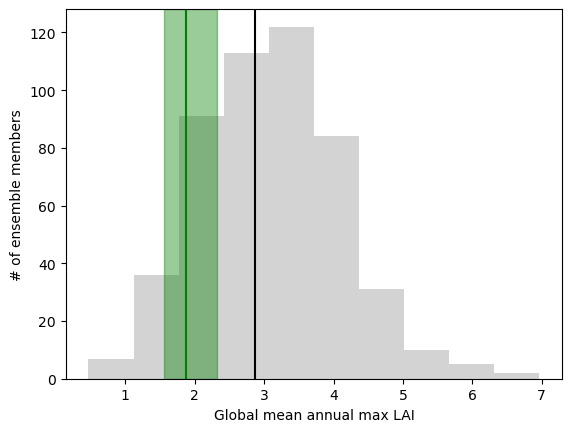

In [54]:
plt.hist(lai,color='lightgrey')
plt.axvline(lai.isel(ens=0).values,c='k',label='CLM-default')
plt.axvline(np.mean(obs_lai_gmean_amax),c='green',label='observational target')
plt.axvspan(np.min(obs_lai_gmean_amax),np.max(obs_lai_gmean_amax),color='green',alpha=0.4,label='observational tolerance')
plt.xlabel('Global mean annual max LAI')
plt.ylabel('# of ensemble members')

In [60]:
# the best parameter set index is:
best_ix = np.argmin(np.abs(lai.values-np.mean(obs_lai_gmean_amax)))
best_ix

14

#### Train emulator 

In [46]:
kernel_dict = build_kernel_dict(num_params)

saving
INFO:tensorflow:Assets written to: ../emulators/laimax_gmean/assets


INFO:tensorflow:Assets written to: ../emulators/laimax_gmean/assets


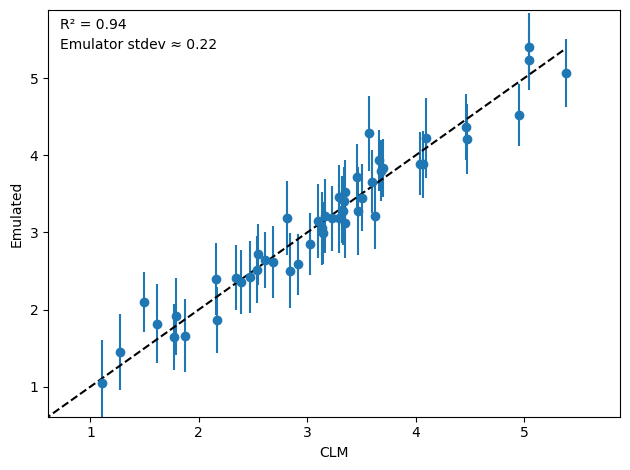

In [61]:
# Train and save emulator

savedir = str('../emulators/laimax_gmean') # where to save emulator
outfile = '../figs/emulator_validation_laimax_gmean.png' # validation figure

ntest = 50
X = ppe_params.values
Y = lai[1:]
X_test, X_train = X[:ntest,:], X[ntest:,:]
y_test, y_train = Y[:ntest].values.reshape(-1,1), Y[ntest:].values.reshape(-1,1)

best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
R2_score, stdev = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile,savedir)

### GPP

In [10]:
sys.path.append('/glade/u/home/linnia/NMopt_wCLMemulator/utils/')
from pyfunctions import *

In [8]:
# get LHC PPE parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
ppe_params = pd.read_csv(lhckey).drop(columns='member')
num_params = len(ppe_params.columns)

In [14]:
# load Latin hypercube ensemble
dvs = ['GPP']
htape='h0'
ds=get_ds(dvs,htape,yr0=2001,yr1=2020)

In [15]:
# calc global mean annual mean GPP
cf = 60*60*24*365*1E-9*ds.la.sum()
gpp=cf*gmean(amean(ds.GPP).mean(dim='year'),ds.la)

In [16]:
kernel_dict = build_kernel_dict(num_params)

2025-02-17 08:34:27.410263: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


saving
INFO:tensorflow:Assets written to: ../emulators/gpp_gmean/assets


INFO:tensorflow:Assets written to: ../emulators/gpp_gmean/assets


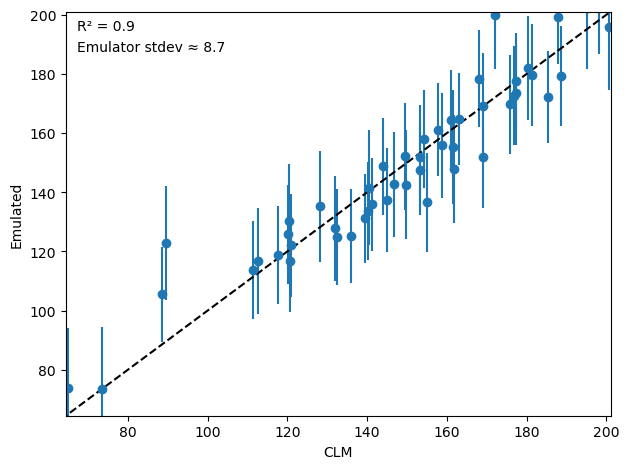

In [21]:
# Train and save emulator

savedir = str('../emulators/gpp_gmean') # where to save emulator
outfile = '../figs/emulator_validation_gpp_amean_gmean.png' # validation figure

ntest = 50
X = ppe_params.values
Y = gpp[1:]
X_test, X_train = X[:ntest,:], X[ntest:,:]
y_test, y_train = Y[:ntest].values.reshape(-1,1), Y[ntest:].values.reshape(-1,1)

best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
R2_score, stdev = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile,savedir)

### Biomass

In [ ]:
sys.path.append('/glade/u/home/linnia/NMopt_wCLMemulator/utils/')
from pyfunctions import *

In [ ]:
# get LHC PPE parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
ppe_params = pd.read_csv(lhckey).drop(columns='member')
num_params = len(ppe_params.columns)

In [22]:
# load Latin hypercube ensemble
dvs = ['TOTVEGC']
htape='h0'
ds=get_ds(dvs,htape,yr0=2001,yr1=2020)

In [23]:
# calc global mean annual mean GPP
cf = 1E-9*ds.la.sum()
biomass=cf*gmean(amean(ds.TOTVEGC).mean(dim='year'),ds.la)

In [24]:
kernel_dict = build_kernel_dict(num_params)

saving
INFO:tensorflow:Assets written to: ../emulators/biomass_gmean/assets


INFO:tensorflow:Assets written to: ../emulators/biomass_gmean/assets


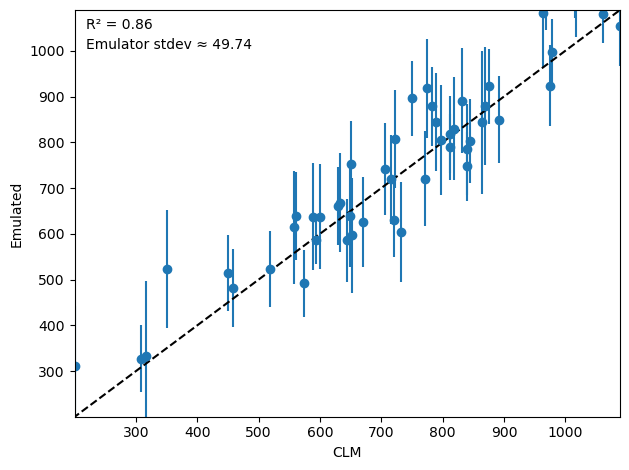

In [27]:
# Train and save emulator

savedir = str('../emulators/biomass_gmean') # where to save emulator
outfile = '../figs/emulator_validation_biomass_amean_gmean.png' # validation figure

ntest = 50
X = ppe_params.values
Y = biomass[1:]
X_test, X_train = X[:ntest,:], X[ntest:,:]
y_test, y_train = Y[:ntest].values.reshape(-1,1), Y[ntest:].values.reshape(-1,1)

best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
R2_score, stdev = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile,savedir)